In [394]:
import sys
#import Backtest
from GeneralBacktest import Backtest,Position,Bid
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import pickle
import yfinance as yf
import pandas_ta as ta
#warnings.filterwarnings("ignore")
from matplotlib.pyplot import figure

# Load sample data

In [404]:
data = pd.read_csv("test_data.csv",index_col = 0)
data.index = pd.to_datetime(data.index)

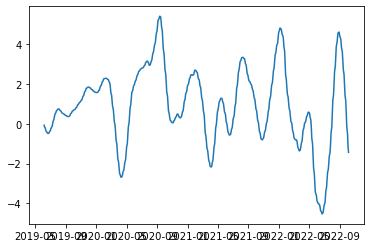

In [452]:
plt.plot(macd.macd['AAPL'])

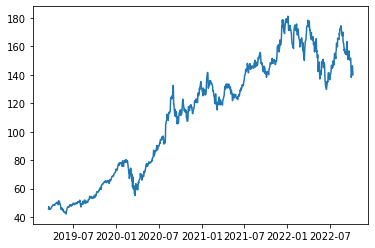

In [453]:
plt.plot(data['AAPL'])

In [515]:
class MACD:
    def __init__(self,data):
        self.data = data
        self.macd = self.get_macd(data)
        self.signal_change = (self.macd*self.macd.shift(1)).lt(0)
        
    def get_macd(self,data):
        res = pd.DataFrame()
        for ticker in data.columns:
            macd = data.ta.macd(close=ticker, fast=12, slow=26, signal=9, append=False)
            res[ticker] = macd['MACD_12_26_9'].rolling(7).mean()
        res.index = data.index
        return res
    
    def get_targets(self,ti):
        buying = []
        selling = []
        
        keys = self.signal_change.loc[ti]
        keys = keys[keys>0].keys()
        
        for key in keys:
            if self.macd.loc[ti][key] > 0:
                buying.append(key)
            else:
                selling.append(key)
        
        
        #print(buying,selling)
        return buying, selling
        
    def predict(self,ti,df,positions,cash,full_data):
#         if ti.minute == 0 or ti.minute == 30:
#             print("================={}=================".format(ti))
        bid_list = []

        
        buying,selling = self.get_targets(ti)
        
        for pos in positions.values():
            ret = (pos.price - pos.wa_cost_price)/pos.wa_cost_price
            if  pos.ticker in selling:
                bid = Bid(ticker = pos.ticker,shares = pos.shares,price = df.iloc[-1][pos.ticker],bid_type = 0)
                bid_list.append(bid)
                cash+=pos.shares * pos.price
                


        
        
        for ticker in buying:
            price = df.iloc[-1][ticker]
            amount = cash/len(buying)*0.2
            shares = amount//price
            bid = Bid(ticker = ticker, shares = shares, price = price,bid_type = 1)
            bid_list.append(bid)

        
        return bid_list
            
        

In [516]:
#data1 = data.iloc[:,:10]
macd = MACD(data)
macd_bt = Backtest(data, macd)
macd_bt.backtest_full()

====================Start====================

#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is invaild
#shares of 0.0 is

# After backtest, check all historical transactions with transaction_history, a dataframe that recorded each bid, its transaction cost and pnl.

In [517]:
macd_bt.transaction_history

,dt,ticker,type,price,shares,amount,transaction_cost,pnl
0,2019-05-06,CVS,1,51.775536,193.0,9992.678368,0.0,0.000000
1,2019-05-06,NEE,1,44.357395,225.0,9980.413914,0.0,0.000000
2,2019-05-07,DHR,1,128.970200,124.0,15992.304749,0.0,0.000000
3,2019-05-08,GE,1,80.110565,159.0,12737.579865,0.0,0.000000
4,2019-05-09,TMO,1,266.859314,38.0,10140.653931,0.0,0.000000
...,...,...,...,...,...,...,...,...
2263,2022-10-07,GILD,0,64.290001,10.0,642.900009,0.0,-11.775513
2264,2022-10-07,ABBV,0,138.759995,127.0,17622.519302,0.0,-546.100388
2265,2022-10-07,LLY,0,326.660004,63.0,20579.580231,0.0,321.931000
2266,2022-10-07,COP,0,118.510002,159.0,18843.090340,0.0,410.220291


<AxesSubplot:>

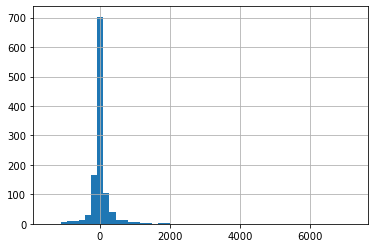

In [518]:
#histogram of pnl
macd_bt.transaction_history[macd_bt.transaction_history.type ==0]['pnl'].hist(bins = 50)

# The portfolio_tracker records the # of bids, length of positions, cash value, position value, total value at each ti. 
# The bah column is the value assuming we buy all the tickers when it begins

In [519]:
macd_bt.portfolio_tracker

,dt,bid_count,position_count,cash_value,positions_value,total_value,bah
0,2019-03-20,0,0,100000.000000,0.000000,100000.000000,100000.000000
1,2019-03-21,0,0,100000.000000,0.000000,100000.000000,100954.473649
2,2019-03-22,0,0,100000.000000,0.000000,100000.000000,99110.452320
3,2019-03-25,0,0,100000.000000,0.000000,100000.000000,99028.807052
4,2019-03-26,0,0,100000.000000,0.000000,100000.000000,99948.807689
...,...,...,...,...,...,...,...
891,2022-09-30,1,7,101177.541698,30260.280838,131437.822536,145482.006651
892,2022-10-03,2,7,81889.492443,50447.760323,132337.252765,147742.010895
893,2022-10-04,1,6,87208.012569,46620.021759,133828.034328,152403.253638
894,2022-10-05,2,6,73821.862674,60363.160156,134185.022830,151698.105409


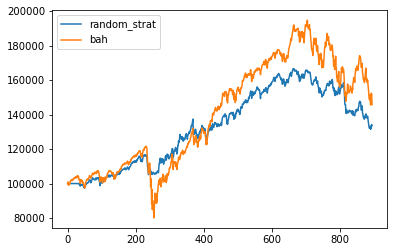

In [520]:
macd_bt.plot()

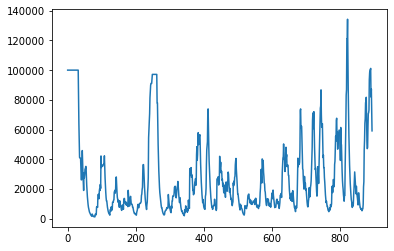

In [521]:
plt.plot(macd_bt.portfolio_tracker['cash_value'])

In [522]:
macd_bt.upload_to_dashboard("MACD")

Data uploaded.


# Check on dashboard:
https://tigaji-algo-trade-dashboard-dashboard-gv8r0a.streamlitapp.com/